In [3]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image as im
from PIL import ImageChops as ic
import random as rd
import _pickle as cPickle

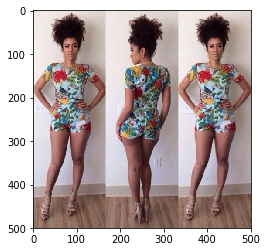

In [4]:
img=plt.imread('../input/train/1.jpg')
imgplot = plt.imshow(img)

In [5]:
labels_file = open('../input/train/labels.csv', 'r') 
labels = labels_file.readlines()
for i in range(len(labels)):
    labels[i] = np.array(labels[i].split(','))

In [6]:
imgArray=[]
RESIZE_SIZE = 32 #Change depending on what input your CNN expects
for j in range(1,10000):
    imgName = '../input/train/' + str(j) +'.jpg'
    img = im.open(imgName).convert("RGB")
    img = img.resize((RESIZE_SIZE, RESIZE_SIZE))
    imgArray.append(np.array(img))



In [7]:
X_train = np.array(imgArray[:8000])
y_train = np.array(labels[:8000])

X_test = np.array(imgArray[8000:9999])
y_test = np.array(labels[8000:9999])

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)


Train data shape:  (8000, 32, 32, 3)
Train labels shape:  (8000, 300)


In [8]:
import keras
from keras.datasets import cifar10
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os
import tensorflow as tf
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [9]:
# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
print('model loaded')

# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    big_X_train = np.array([scipy.misc.imresize(X_train[i], (139, 139, 3)) 
                            for i in range(0, len(X_train))]).astype('float32')
    inception_input_train = preprocess_input(big_X_train)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
    
print('bottleneck features saved (train)')

model loaded
bottleneck features file not detected (train)
calculating now ...


/Users/ianlee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


train data preprocessed
bottleneck features saved (train)


In [10]:
# obtain bottleneck features (test)
if os.path.exists('inception_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_X_test = np.array([scipy.misc.imresize(X_test[i], (139, 139, 3)) 
                       for i in range(0, len(X_test))]).astype('float32')
    inception_input_test = preprocess_input(big_X_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...


/Users/ianlee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


bottleneck features saved (test)


In [11]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(300, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(features, y_train, batch_size=50, epochs=50,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 1, 1, 32)          589856    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               9900      
Total params: 599,756
Trainable params: 599,756
Non-trainable params: 0
_________________________________________________________________
Train on 6400 samples, validate on 1600 samples
Epoch 1/50
 - 4s - loss: 64.6116 - acc: 0.0411 - val_loss: 35.2684 - val_acc: 0.1419

Ep


Epoch 00050: val_loss did not improve
